# Explore Zenodo community

In [1]:
from zenodoExplorer.zenexp import ze

recIDs = [10835267, 10712131, 10890165]
with open("api.key", "r") as keyFile:
    ACCESS_TOKEN = keyFile.readline().rstrip()

z = ze(ACCESS_TOKEN, recIDs, cache='~/.zenodo_cache/')
z.read_zdb()
# z.zdb.del_dat_tree('td1@10835267')
# z.zdb.del_dat_tree('td1@10890165')
# z.zdb.del_dat_tree('ml3@10835267')
# z.zdb.del_dat_tree('md2@10835267')
# z.zdb.del_dat_tree('md1@10712131')
z.zdb.plot()

In [2]:
z.zdb.to_pd('AtomicConfigs')

,desc
tag,
ac1@10835267,"EC:EMC liquid PBC, isolated mols, volume scans..."
ac1@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 25% of all ..."
ac2@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 7% of all n..."


,at_conf,ab_init_code,ab_init_theo,zip,file
tag,,,,,
td1@10835267,ac1@10835267,CASTEP,PBE-D2,TrainData,Train16_PBED2.xyz
td2@10835267,ac1@10835267,CP2K,PBE-D3,TrainData,Train16_PBED3.xyz
td1@10712131,ac1@10835267,VASP,B97-D3BJ,TrainData_IBM23,IBM23_B97D3BJ_Vasp.xyz
td2@10712131,ac1@10712131,PSI4,B97-D3BJ,TrainData_SD22,SD22NQ_B97D3BJ_Psi4.xyz
td3@10712131,ac1@10712131,PSI4,wB97X-D3BJ,TrainData_SD22,SD22NQ_wB97XD3BJ_Psi4.xyz
td4@10712131,ac2@10712131,PSI4,wB97X-D3BJ,TrainData_SD22,SD22NQQ_wB97XD3BJ_Psi4.xyz
td1@10890165,ac1@10835267,CASTEP (ASE+LAMMPS),PBE-D2 (-fixed charge baseline),TrainData_IBM23,IBM23_PBED2_Castep-LR.xyz


In [4]:
z.zdb.to_pd('MLIPs')

,tr_data,ml_code,ml_settings,fit_prop,zip,file
tag,,,,,,
ml1@10835267,td1@10835267,GAP,"DS, Rcut 3/6","energy, forces, virial",MLIP_GAP_Gen16DS_PBED2,gapmodel.xml
ml2@10835267,td1@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial",MLIP_GAP_Gen16DTS_PBED2,gapmodel.xml
ml3@10835267,td2@10835267,GAP,"DS, Rcut 3/6","energy, forces, virial",MLIP_GAP_Gen16DS_PBED3,gapmodel.xml
ml4@10835267,td2@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial",MLIP_GAP_Gen16DTS_PBED3,gapmodel.xml
ml1@10712131,td1@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces",MLIP_MACE_IBM23_B97,macemodel.model
ml2@10712131,td2@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces",MLIP_MACE_SD22NQ_B97,macemodel.model
ml3@10712131,td3@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces",MLIP_MACE_SD22NQ_wB97X,macemodel.model
ml4@10712131,td4@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces",MLIP_MACE_SD22NQQ_wB97X,macemodel.model
ml5@10712131,td2@10835267,MACE,"Layers 2, Rcut 6+6","energy, forces, virial",MLIP_MACE_IBM23_PBE,macemodel.model


In [5]:
z.zdb.to_pd('MDSims')

,pes_model,md_code,md_system,md_no_at,md_ensmb,md_step,md_len,md_temp,md_pres,zip,file
tag,,,,,,,,,,,
md1@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,300 K,1 atm,MDSims_1000Atoms_1000ps_300K_NPT_Gen16DTS_PBED3,"*.thermo, *.lammpstrj"
md2@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,350 K,1 atm,MDSims_1000Atoms_1000ps_350K_NPT_Gen16DTS_PBED3,"*.thermo, *.lammpstrj"
md1@10712131,ml3@10712131,ASE,EMC,1000,NPT,1.0 fs,1.0 ns,298 K,1 atm,MDSims_1000Atoms_05fs_MACE_SD22NQ_wB97X,"test-1fs/npt_000conEC_298K.thermo, test-1fs/np..."
md2@10712131,ml3@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,0.5 fs,0.5-1.0 ns,"298, 298, 298, 313 K",1 atm,MDSims_1000Atoms_05fs_MACE_SD22NQ_wB97X,"npt_*.thermo, npt_*.xyz"
md3@10712131,ml4@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.5 ns,"298, 298, 298, 313 K",1 atm,MDSims_1000Atoms_1fs_MACE_SD22NQQ_wB97X,"npt_*.thermo, npt_*.xyz"
md4@10712131,ml1@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm,MDSims_1000Atoms_1fs_MACE_IBM23_B97,"npt_*.thermo, npt_*.xyz"
md5@10712131,ml2@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm,MDSims_1000Atoms_1fs_MACE_SD22NQ_B97,"npt_*.thermo, npt_*.xyz"
md6@10712131,ml5@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,"298, 298, 298, 313 K",1 atm,MDSims_1000Atoms_1fs_MACE_IBM23_PBE,"npt_*.thermo, npt_*.xyz"
md7@10712131,ml4@10890165,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,"298, 298, 298, 298 K",1 atm,MDSims_1000Atoms_1fs_MACE_IBM23_PBE_D2,"npt_*.thermo, npt_*.xyz"


# Training Sets

In [2]:
z.zdb.to_pd('TrainData')

,at_conf,ab_init_code,ab_init_theo,zip,file
tag,,,,,
td1@10835267,ac1@10835267,CASTEP,PBE-D2,TrainData,Train16_PBED2.xyz
td2@10835267,ac1@10835267,CP2K,PBE-D3,TrainData,Train16_PBED3.xyz
td1@10712131,ac1@10835267,VASP,B97-D3BJ,TrainData_IBM23,IBM23_B97D3BJ_Vasp.xyz
td2@10712131,ac1@10712131,PSI4,B97-D3BJ,TrainData_SD22,SD22NQ_B97D3BJ_Psi4.xyz
td3@10712131,ac1@10712131,PSI4,wB97X-D3BJ,TrainData_SD22,SD22NQ_wB97XD3BJ_Psi4.xyz
td4@10712131,ac2@10712131,PSI4,wB97X-D3BJ,TrainData_SD22,SD22NQQ_wB97XD3BJ_Psi4.xyz
td1@10890165,ac1@10835267,CASTEP (ASE+LAMMPS),PBE-D2 (-fixed charge baseline),TrainData_IBM23,IBM23_PBED2_Castep-LR.xyz


In [258]:
from aseMolec import anaAtoms as aa
from ase.io import read

path = z.read_dat_files('td1@10835267', '.xyz')[0]
IBM23 = read(path, ':')

path = z.read_dat_files('td3@10712131', '.xyz')[0]
SD22NQ = read(path, ':')
aa.wrap_molecs(SD22NQ)

path = z.read_dat_files('td4@10712131', '.xyz')[0]
SD22NQQ = read(path, ':')

SD22N = read('/Users/nim92/Home/Research/Newcastle/local/04-Finalize-BigMAP-Kersti/01-largerData-SchrodClust/data_molecs.xyz', ':')

In [288]:
from collections import Counter

def collect_comp(db):
    buf = {}
    for at in db:
        at.info['Nmols'] 
        if at.info['Nmols'] in buf:
            buf[at.info['Nmols']] += [at.info['Comp']]
        else:
            buf[at.info['Nmols']] = [at.info['Comp']]
    comp = {}
    for b in buf:
        comp[b] = dict(Counter(buf[b]))
    return comp

In [289]:
def wrap_labels(labels):
    wrapped_labels = []
    for label in labels:
        parts = label.split(':')
        for i in range(1, len(parts) - 1, 2):
            parts[i] += '\n'
        wrapped_labels.append(':'.join(parts))
    return wrapped_labels

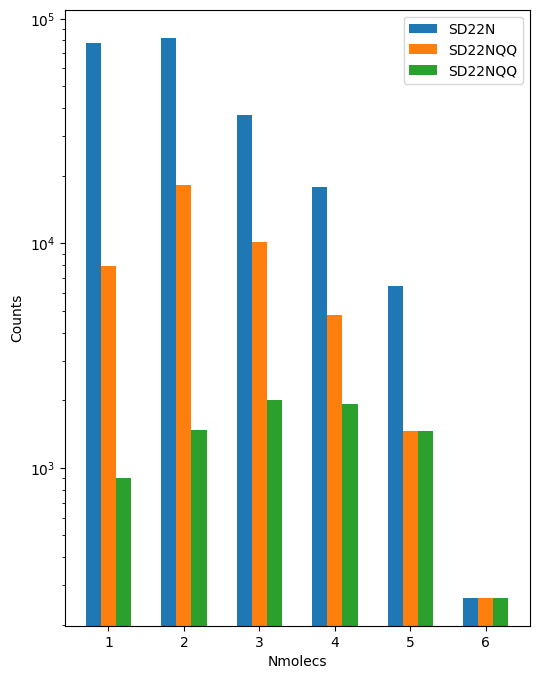

In [319]:
import numpy as np
from matplotlib import pyplot as plt

stats_SD2N   = np.histogram(np.array([at.info['Nmols'] for at in SD22N]), [1,2,3,4,5,6,7])[0]
stats_SD2NQ  = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ]), [1,2,3,4,5,6,7])[0]
stats_SD2NQQ = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ]), [1,2,3,4,5,6,7])[0]

bw = 0.2
plt.figure(figsize=(6,8))
plt.bar(np.arange(1,7,1)-bw, stats_SD2N, width=bw, label = 'SD22N')
plt.bar(np.arange(1,7,1), stats_SD2NQ, width=bw, label = 'SD22NQQ')
plt.bar(np.arange(1,7,1)+bw, stats_SD2NQQ, width=bw, label = 'SD22NQQ')
plt.yscale('log')
plt.xlabel('Nmolecs')
plt.ylabel('Counts')
plt.legend()

In [300]:
stats_SD2N

(array([77880, 82253, 37176, 17787,  6464,   264]),
 array([1, 2, 3, 4, 5, 6, 7]))

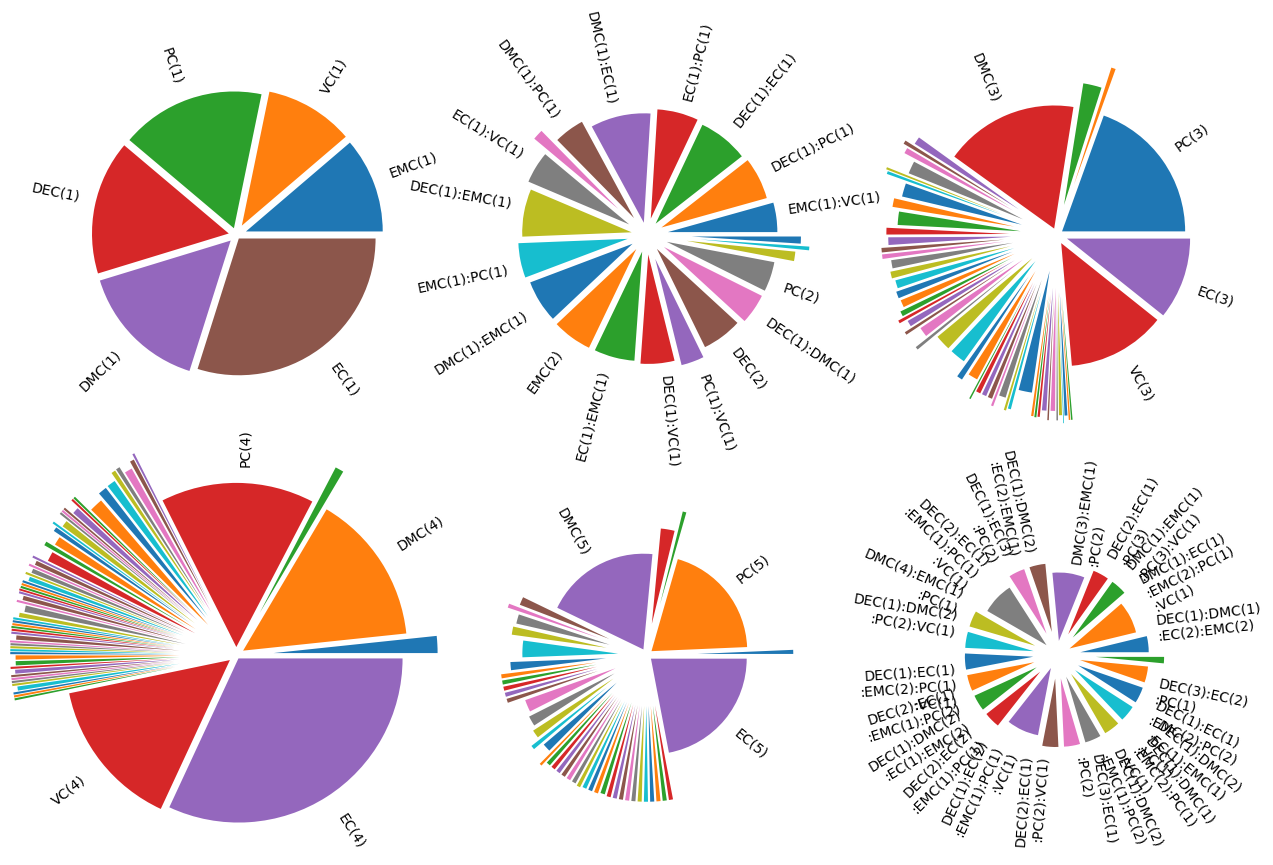

In [284]:
import numpy as np
from matplotlib import pyplot as plt

comp_dict = collect_comp(SD22NQ)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
ax = axes.flatten()

radius = [1,0.8,0.9,1.2,0.7,0.5]
for i, Nmol in enumerate(sorted(comp_dict.keys())):
    counts = np.array(list(comp_dict[Nmol].values()))
    percs = counts/counts.sum()
    labels = list(comp_dict[Nmol].keys())
    for j, perc in enumerate(percs):
        if perc<0.03:
            labels[j] = ''
    ax[i].pie(percs, labels=wrap_labels(labels), radius=radius[i], explode=0.01/(0.02+percs), rotatelabels =True, textprops={'fontsize': 10});
    ax[i].set_axis_off()

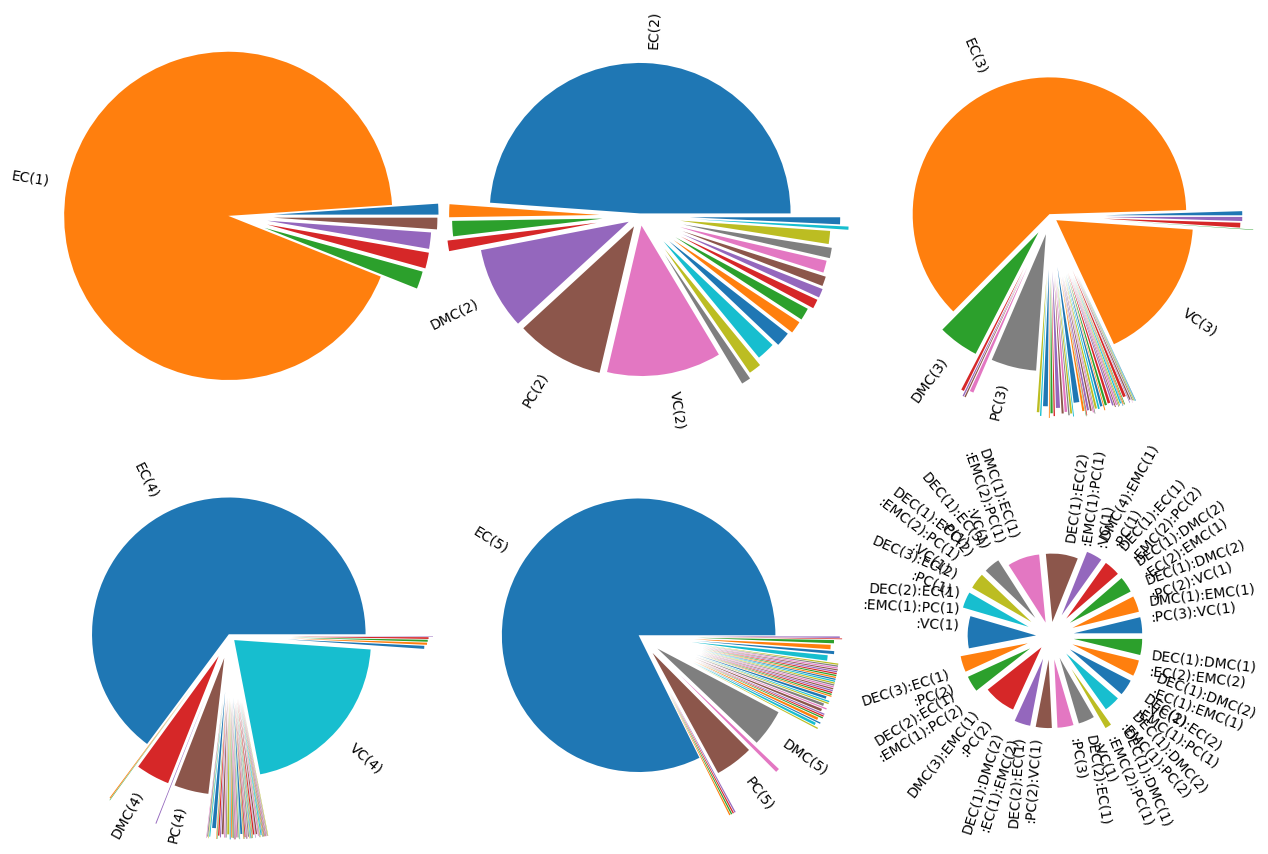

In [321]:
import numpy as np
from matplotlib import pyplot as plt

comp_dict = collect_comp(SD22N)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
ax = axes.flatten()

radius = [1.2,1.1,1,1.0,1.0,0.5]
for i, Nmol in enumerate(sorted(comp_dict.keys())):
    counts = np.array(list(comp_dict[Nmol].values()))
    percs = counts/counts.sum()
    labels = list(comp_dict[Nmol].keys())
    for j, perc in enumerate(percs):
        if perc<0.03:
            labels[j] = ''
    ax[i].pie(percs, labels=wrap_labels(labels), radius=radius[i], explode=0.01/(0.02+percs), rotatelabels =True, textprops={'fontsize': 10});
    ax[i].set_axis_off()

# Get MD trajectories

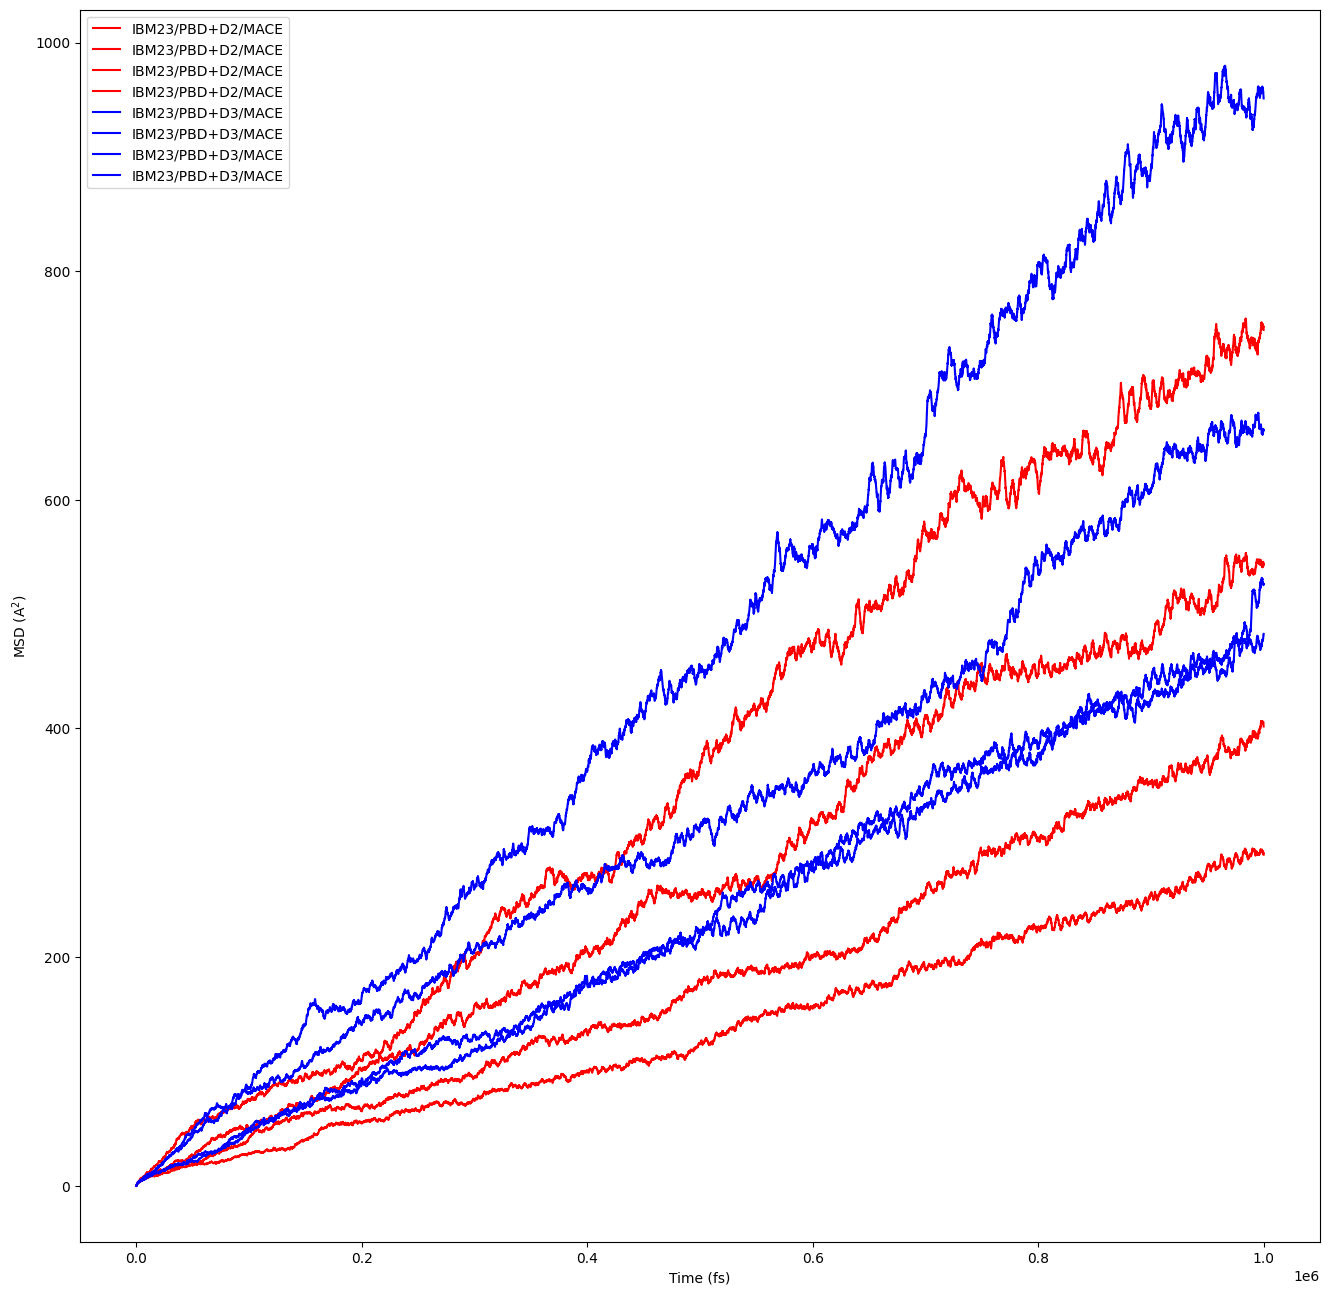

In [19]:

labels = []
paths = []

labels += ['IBM23/PBD+D2/MACE']*4
paths += z.read_dat_files('md7@10712131', ext='.thermo')

labels += ['IBM23/PBD+D3/MACE']*4
paths += z.read_dat_files('md6@10712131', ext='.thermo')

from aseMolec import pltProps as pp
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16,16))
for path, label in zip(paths, labels):
    if 'D2' in label:
        color = 'red'
    if 'D3' in label:
        color = 'blue'
    thermo = pp.loadtxttag(path)
    pp.simpleplot(thermo, 'Time', 'MSD', byKey=True, label=label, color=color)
plt.legend()


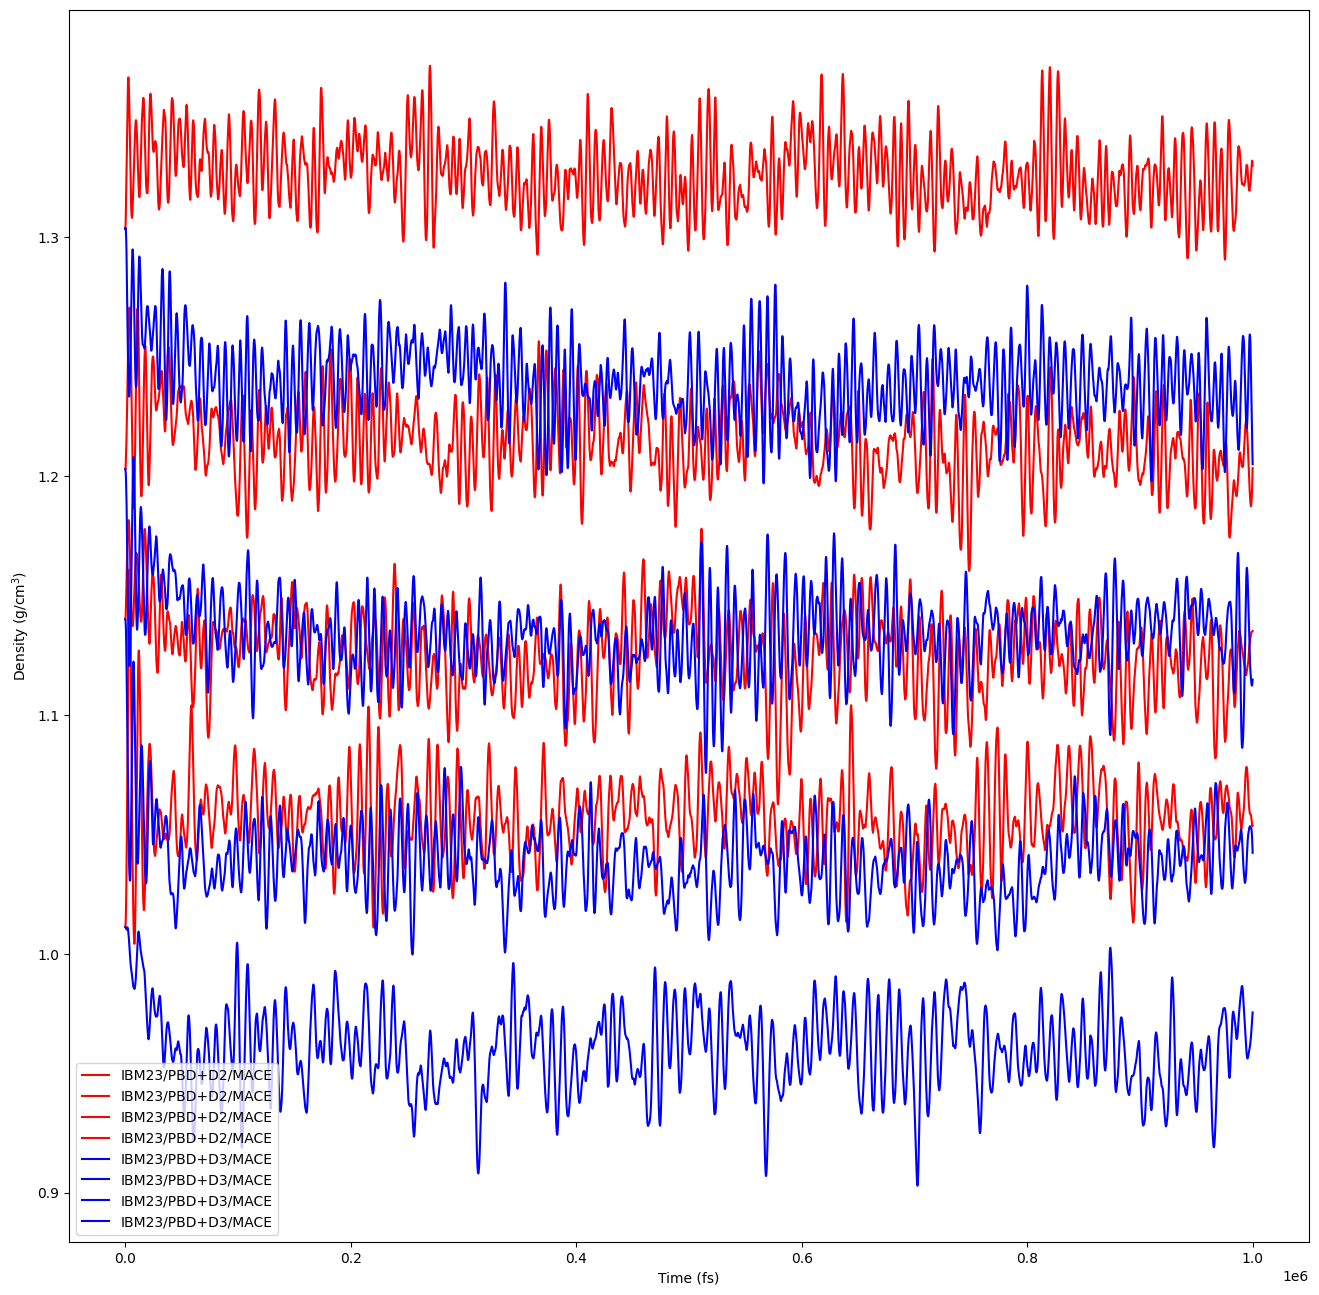

In [20]:
fig = plt.figure(figsize=(16,16))
for path, label in zip(paths, labels):
    if 'D2' in label:
        color = 'red'
    if 'D3' in label:
        color = 'blue'
    thermo = pp.loadtxttag(path)
    pp.simpleplot(thermo, 'Time', 'Density', byKey=True, label=label, color=color)
plt.legend()


### All these on PBE+D2

In [163]:
labels = []
paths = []

labels += ['MACE (NPT)', 'MACE (NVT)']
paths = z.read_dat_files('md4@10890165', ext='.thermo')

labels += ['GAP (NPT1)', 'GAP (NPT2)', 'GAP (NPT3)', 'GAP (NVT1)', 'GAP (NVT2)', 'GAP (NVT3)'] # different starting configs
paths += z.read_dat_files('md1@10890165', ext='.thermo')

labels += ['GAP1 (NPT)', 'GAP2 (NPT)', 'GAP3 (NPT)', 'GAP1 (NVT)', 'GAP2 (NVT)', 'GAP3 (NVT)'] # different GAP models
paths += z.read_dat_files('md2@10890165', ext='.thermo')

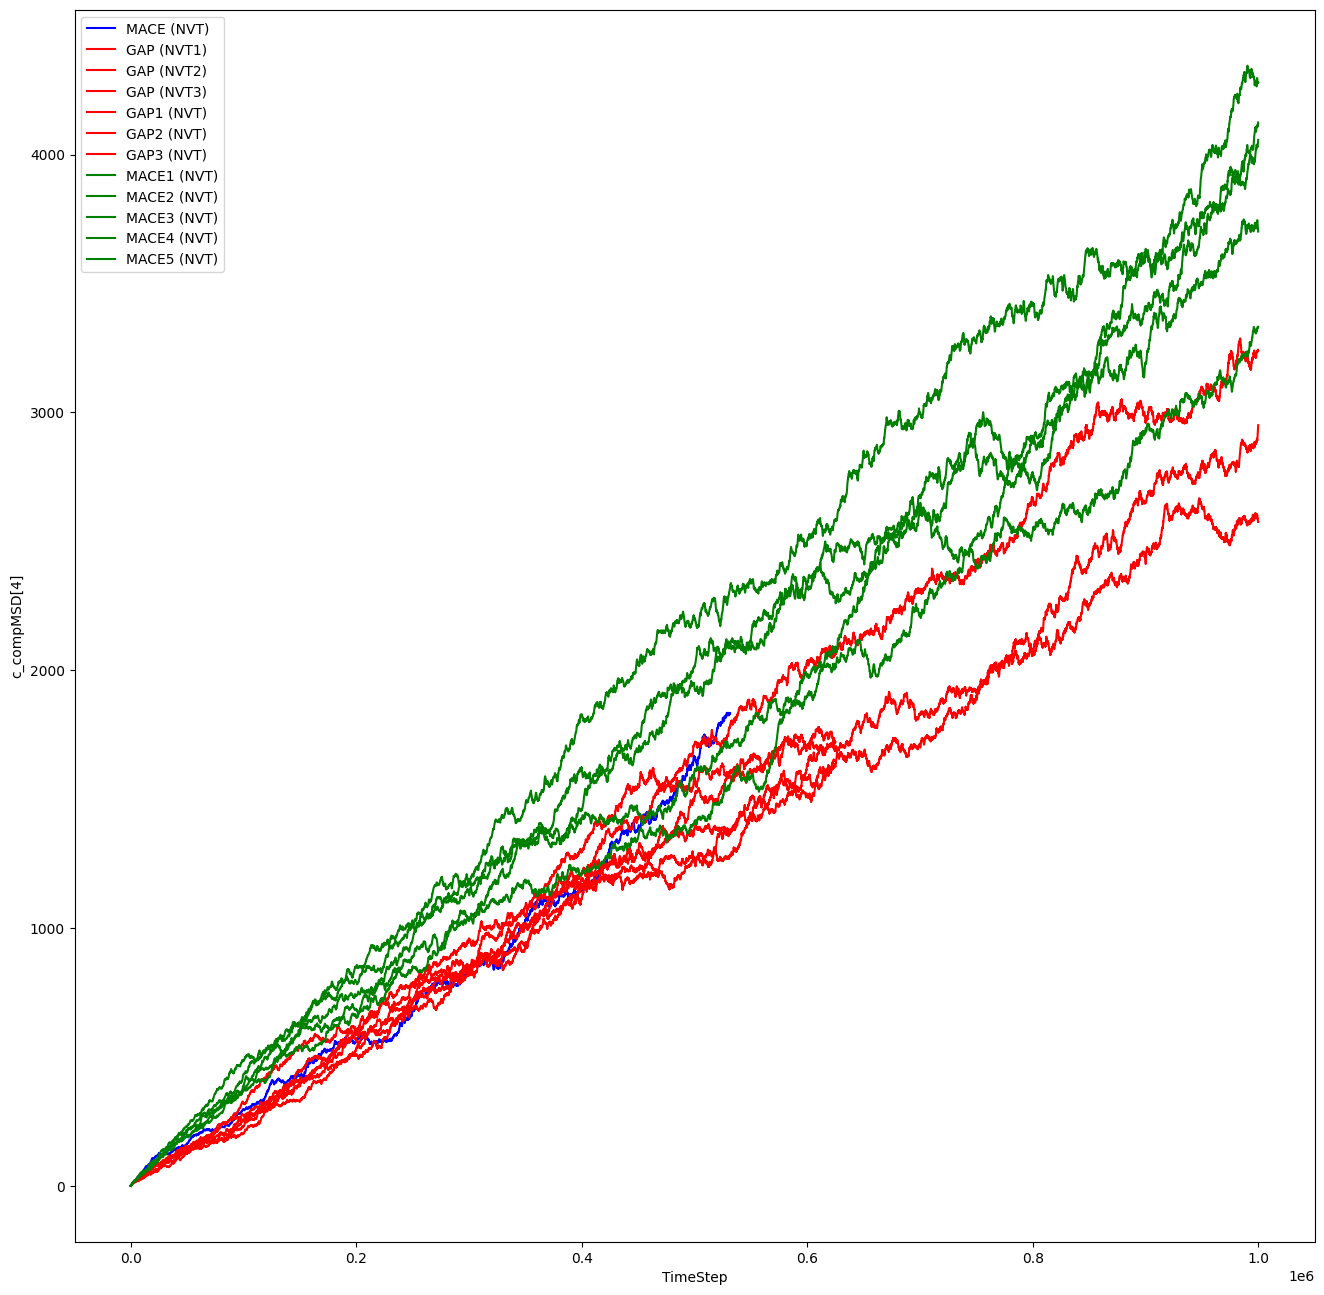

In [172]:
from aseMolec import pltProps as pp
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16,16))
for path, label in zip(paths, labels):
    if 'NVT' in label:
        if 'GAP' in label:
            color = 'red'
        if 'MACE' in label:
            color = 'blue'
        thermo = pp.loadtxttag(path)
        pp.simpleplot(thermo,'TimeStep', 'c_compMSD[4]', byKey=True, label=label, color=color)
plt.plot(np.arange(0,1e+6+1,100), D.T, color='green', label=['MACE1 (NVT)', 'MACE2 (NVT)', 'MACE3 (NVT)', 'MACE4 (NVT)', 'MACE5 (NVT)'])
plt.legend()

actually 500K, MACE and GAP seem to agree. These were done with Lammps, not ASE. further investigation.

In [162]:
from ase.io import read
from glob import glob
import numpy as np

paths = sorted(glob('/Users/nim92/Downloads/MDSims_MACE4exp_NVT/QBC_*'))
dcol = []

for path in paths:
    print(path)
    traj = read(path, ':')
    d = []
    for at in traj:
        d += [((at.positions-traj[0].positions)**2).mean(0).sum(0)]
    dcol += [d]

D = np.array(dcol)


/Users/nim92/Downloads/MDSims_MACE4exp_NVT/QBC_1_MD.xyz
/Users/nim92/Downloads/MDSims_MACE4exp_NVT/QBC_2_MD.xyz
/Users/nim92/Downloads/MDSims_MACE4exp_NVT/QBC_3_MD.xyz
/Users/nim92/Downloads/MDSims_MACE4exp_NVT/QBC_4_MD.xyz
/Users/nim92/Downloads/MDSims_MACE4exp_NVT/QBC_5_MD.xyz


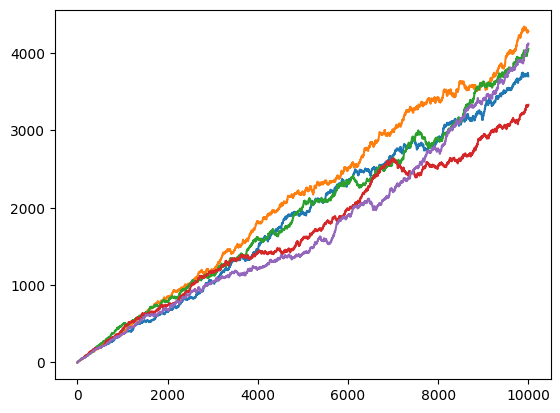

In [165]:
plt.plot(D.T)

In [57]:
import os
from aseMolec import pltProps as pp

def get_all_thermo(tag):
    thermo = {}
    flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

tags = ['md1@10835267', 'md6@10712131', 'md7@10712131', 'md3@10712131', 'md2@10712131', 'md4@10712131', 'md5@10712131']
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(tag)

# from old paper, will be replaced with MACE MD
pp.rename_key(thermo['md1@10835267'], 'TimeStep', 'Time')
pp.rename_key(thermo['md1@10835267'], 'v_mdensity', 'Density')
pp.rename_key(thermo['md1@10835267'], 'c_compMSD[4]', 'MSD')
pp.convert_units(thermo['md1@10835267'], 'Density', 'g/cm$^3$', 1.0)
pp.convert_units(thermo['md1@10835267'], 'MSD', 'A$^2$', 1.0)
thermo['md1@10835267'] = {
    k_new : thermo['md1@10835267'][k_old]
    for k_old, k_new in zip(['67EMC_300K', '25EC_50EMC_300K', '57EC_29EMC_300K', '100EC_300K'],
                            ['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
}

#D2 trajectory for pure EC was performed at 298, but will rename the key so the code works
thermo['md7@10712131']['npt_100conEC_313K'] = thermo['md7@10712131'].pop('npt_100conEC_298K')

for tag in thermo:
    pp.convert_units(thermo[tag], 'Time', 'ps', 0.001)

def_cols = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
def_lege = ['EMC', 'EC:EMC (3:7)', 'EC:EMC (7:3)', 'EC']
def_conc = [0/67, 25/75, 57/(29+57), 100/100]
def_meth = ['GAP_IBM23_PBE', 'MACE_IBM23_PBE', 'MACE_IBM23_PBE(D2)', 'MACE_SD22NQQ_wB97X', 'MACE_SD22NQ_wB97X', 'MACE_IBM23_B97', 'MACE_SD22NQ_B97']

In [58]:
for k in thermo:
    print(thermo[k].keys())

dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])


# Compare MD trajectories

## compute average densities and diffusivities

In [59]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aseMolec import pltProps as pp
import ase.units
densfact = (ase.units.m/1.0e2)**3/ase.units.mol

def compute(thermo_md, t0=0):
    # t0: in picoseconds, how much of the MD traj to ignore from the start
    idx = np.where(thermo_md['Time']['data']>t0)[0][0]
    t = thermo_md['Time']['data'][idx:]
    dens = thermo_md['Density']['data'][idx:]
    msd = thermo_md['MSD']['data'][idx:]

    dens_avg = dens.mean() #g/cm^3
    D, offs = np.polyfit(t, msd, deg=1)
    D /= 6 #final unit: A^2/ps
    D *= 100 #final unit: 10^-10 m^2/s or 10^-6 cm^2/s
    return dens_avg, D, offs

dens_col = []
diff_col = []
offs_col = []
for tag in tags:
    dens = dict()
    diff = dict()
    offs = dict()
    for k in thermo[tag]:
        rho, D, o = compute(thermo[tag][k], t0=100)
        dens[k] = rho
        diff[k] = D
        offs[k] = o
    dens_col.append(dens)
    diff_col.append(diff)
    offs_col.append(offs)

dens_df_comp = pd.DataFrame(dens_col).round(2)
dens_df_comp.index = def_meth
dens_df_comp.columns = def_lege

diff_df_comp = pd.DataFrame(diff_col).round(2)
diff_df_comp.index = def_meth
diff_df_comp.columns = def_lege

## plot densities and diffusivities

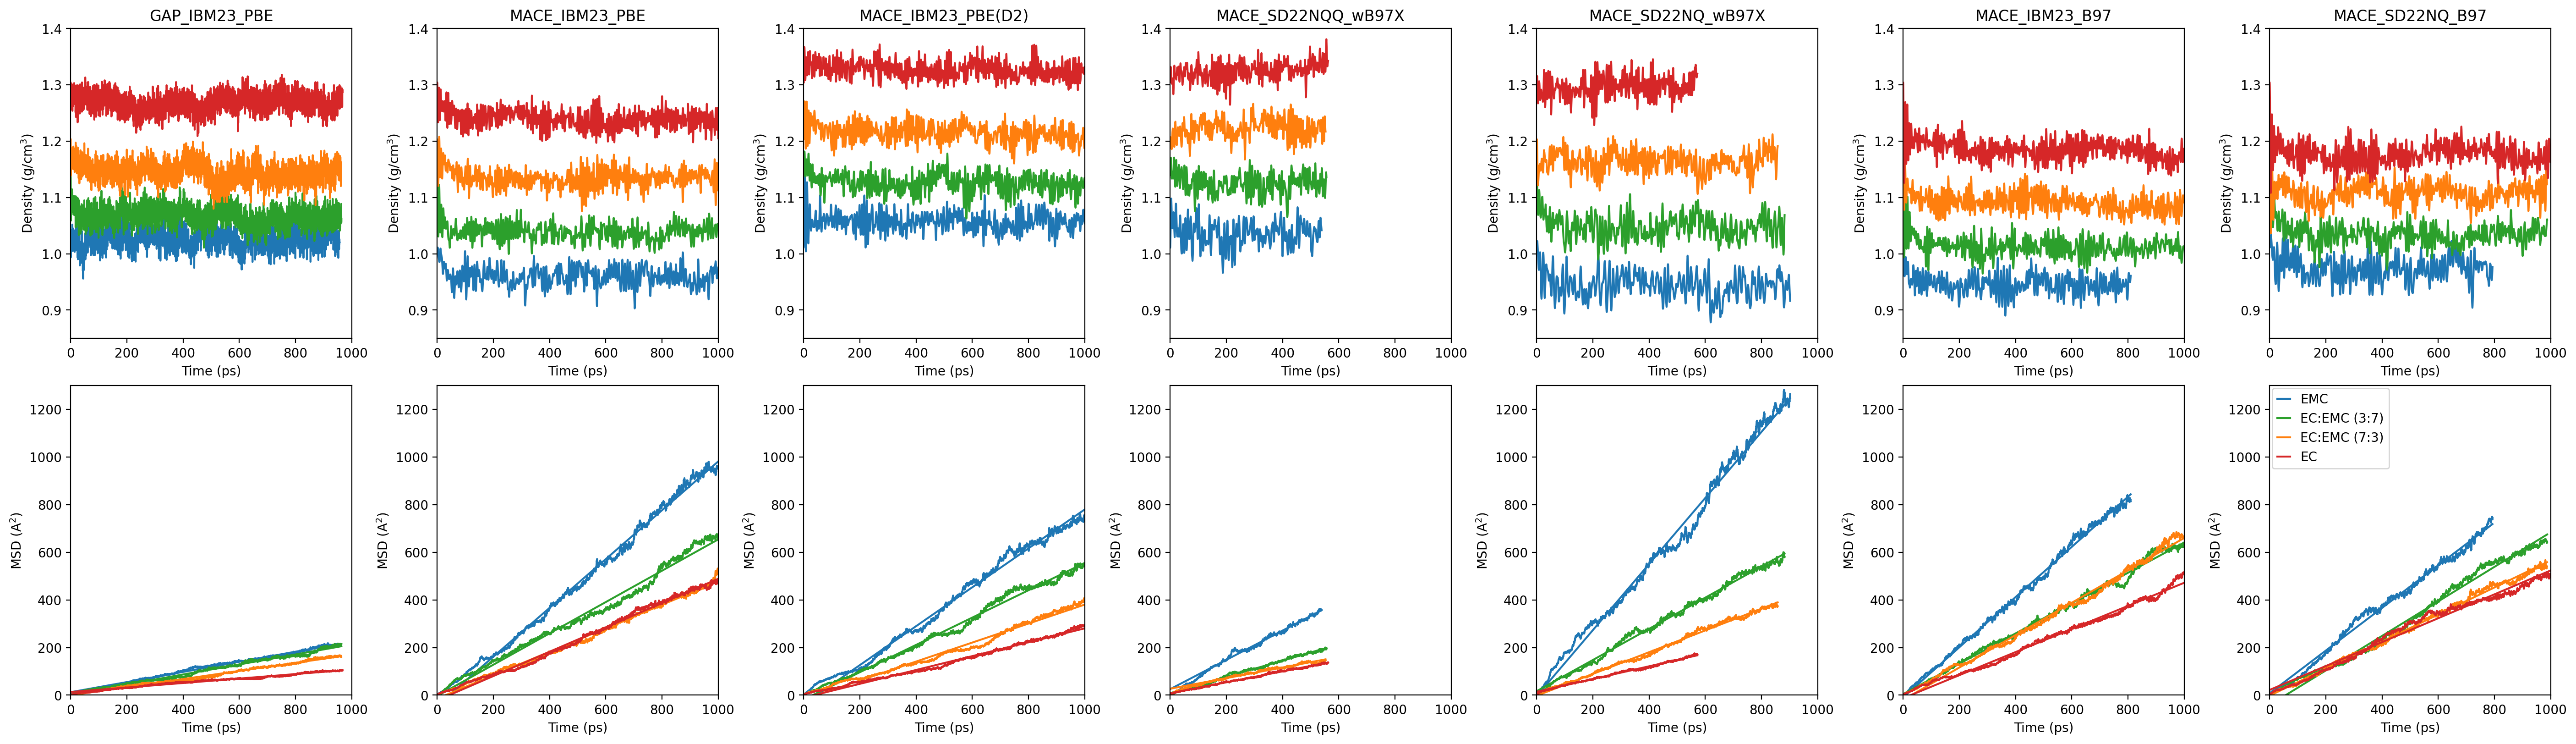

In [62]:
fig, axes = plt.subplot_mosaic(mosaic='ABCDEFG;HIJKLMN', figsize=(28,8), dpi=200, layout='constrained')

# Density
for tag, panel, title in zip(tags, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], def_meth): #loop over methods
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]): #loop over compositions
        pp.simpleplot(thermo[tag][k], 'Time', 'Density', byKey=True, color=def_cols[i])
    plt.xlim([0,1000])
    plt.ylim([0.85,1.4])
    plt.title(title)

# Diffusivity
for j, (tag, panel) in enumerate(zip(tags, ['H', 'I', 'J', 'K', 'L', 'M', 'N'])): #loop over methods
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]): #loop over compositions
        pp.simpleplot(thermo[tag][k], 'Time', 'MSD', byKey=True, color=def_cols[i])
        plt.plot(thermo[tag][k]['Time']['data'], thermo[tag][k]['Time']['data']*diff_col[j][k]/100*6+offs_col[j][k], color=def_cols[i], label='_nolegend_')
    plt.xlim([0,1000])
    plt.ylim([0,1300])

plt.legend(def_lege, handlelength=1, loc='upper left', borderaxespad=0.2)


## Add Schrodinger data and experiment: Holly, 

In [63]:
from joblib import load

exp_dens = load('.cache/exp/dens.joblib');
exp_dens_vals = exp_dens.predict(pd.DataFrame({'xEC': [0/67, 25/75, 57/(29+57), 100/100], 'Temp': [25, 25, 25, 40]}))

dens_schrod = pd.DataFrame({'EMC': 0.99, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 1.35}, index=['Original Schrod'])
dens_experiment = pd.DataFrame({'EMC': 1.01, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 1.32}, index=['Experiment'])
dens_experiment_GPR = pd.DataFrame({'EMC': exp_dens_vals[0], 'EC:EMC (3:7)': exp_dens_vals[1], 'EC:EMC (7:3)': exp_dens_vals[2], 'EC': exp_dens_vals[3]}, index=['Experiment (GPR)'])
dens_df = pd.concat([dens_df_comp.iloc[:3], dens_schrod, dens_df_comp.iloc[3:], dens_experiment])
# dens_df = pd.concat([dens_df_comp.iloc[:3], dens_schrod, dens_df_comp.iloc[3:], dens_experiment_GPR])
dens_df.round(2)

,EMC,EC:EMC (3:7),EC:EMC (7:3),EC
GAP_IBM23_PBE,1.03,1.07,1.14,1.27
MACE_IBM23_PBE,0.96,1.04,1.13,1.24
MACE_IBM23_PBE(D2),1.06,1.12,1.21,1.33
Original Schrod,0.99,NaN,NaN,1.35
MACE_SD22NQQ_wB97X,1.03,1.12,1.22,1.33
MACE_SD22NQ_wB97X,0.94,1.05,1.16,1.30
MACE_IBM23_B97,0.94,1.01,1.09,1.18
MACE_SD22NQ_B97,0.97,1.03,1.11,1.18
Experiment,1.01,NaN,NaN,1.32


# Compute diffusion correction

Our simulations have the same number of molecules as Schrodinger 100 EC and 67 EMC, so we can compute total masses from our starting configs:

In [64]:
from ase.io import read

EC = read(z.read_dat_files('md2@10712131', ext='.xyz')[-1], '0')
EMC = read(z.read_dat_files('md2@10712131', ext='.xyz')[0], '0')

print(EC.get_masses().sum())
print(EMC.get_masses().sum())

8806.199999999999
6975.034999999999


For the diffusion data, we first need to compute the correction coefficients used by [Schrodinger SI, equ 5](https://pubs.acs.org/doi/suppl/10.1021/acs.jpcb.2c03746/suppl_file/jp2c03746_si_001.pdf) and [Bamboo, equ 61](https://arxiv.org/pdf/2404.07181), quoting [standard practice, equ 3](https://livecomsjournal.org/index.php/livecoms/article/view/v1i1e6324/937).
$$
D(\infty)=D(L)+\frac{2.837298\times k_BT}{6\pi \eta L}
$$
Box sizes are computed from number of molecules (table S1) and densities (table S2) from Schrodinger, temperatures are taken from table S1 and viscosity from table S3:

In [65]:
import ase.units

M_EC = EC.get_masses().sum()
M_EMC = EMC.get_masses().sum()

m_EC = M_EC/100
m_EMC = M_EMC/67

V_EC = M_EC/1.35*densfact
V_EMC = M_EMC/0.99*densfact

L_EC = V_EC**(1/3) #A
L_EMC = V_EMC**(1/3) #A

T_EC = 313 #K
T_EMC = 298 #K

n_EC = 2.27 #cP
n_EMC = 0.65 #cP=10^-3 N s m^-2

f_EC = 2.837298*T_EC*ase.units.kB/(6*np.pi*n_EC*L_EC) #eV/A*cP
f_EMC = 2.837298*T_EMC*ase.units.kB/(6*np.pi*n_EMC*L_EMC)
[f_EC, f_EMC]

[8.0833942636879e-05, 0.00026195461179295067]

According to [Wolfram Alpha](https://www.wolframalpha.com/input?i=ev%2F%28centipoise+*+angstrom%29), $\rm 1 eV/(Å cP)$ (electronvolt per ångström centipoise) equals $\rm 1.602×10^{-6} m^2/s$ (square meters per second), equivalent to $\rm 16,020×10^{-10} m^2/s$ or $\rm 16,020×10^{-6} cm^2/s$

In [66]:
f_EC *= 16020
f_EMC *= 16020
[f_EC, f_EMC]

[1.2949597610428016, 4.19651288092307]

experiment

In [67]:
V_EC = M_EC/1.32*densfact
V_EMC = M_EMC/1.01*densfact

L_EC = V_EC**(1/3) #A
L_EMC = V_EMC**(1/3) #A

T_EC = 313 #K
T_EMC = 298 #K

n_EC = 1.90 #cP
n_EMC = 0.65 #cP=10^-3 N s m^-2

f_exp_EC = 2.837298*T_EC*ase.units.kB/(6*np.pi*n_EC*L_EC) #eV/A*cP
f_exp_EMC = 2.837298*T_EMC*ase.units.kB/(6*np.pi*n_EMC*L_EMC)

f_exp_EC *= 16020
f_exp_EMC *= 16020
[f_exp_EC, f_exp_EMC]

[1.5355899131998199, 4.224584035738092]

experiment using the GPR fitted to experimental data

In [68]:
exp_visc = load('.cache/exp/visc.joblib');
exp_visc_vals = exp_visc.predict(pd.DataFrame({'xEC': [0/67, 25/75, 57/(29+57), 100/100], 'Temp': [25, 25, 25, 40]}))

Ts = [298, 298, 298, 313]
f_exps = []
for i in range(4):
    M = read(z.read_dat_files('md2@10712131', ext='.xyz')[i]).get_masses().sum()
    V = M/exp_dens_vals[i]*densfact
    L = V**(1/3)
    n = exp_visc_vals[i]
    f_exp = 16020*2.837298*Ts[i]*ase.units.kB/(6*np.pi*n*L) #eV/A*cP
    print(exp_dens_vals[i], M, L, n, Ts[i], f_exp)
    f_exps += [f_exp]

1.007240693994971 6975.034999999999 22.57117005078735 0.6800845267730196 298 4.034023088427106
1.0932397237750542 7406.799999999998 22.407226366193044 0.771913036454279 298 3.5801305953227742
1.2006113427778147 8038.578999999999 22.31902974199871 1.7815471472277704 298 1.5573374061858687
1.3183346919546466 8806.199999999999 22.301666557196082 1.8962203533821356 313 1.5380034074840967


In [69]:
exp_diff = load('.cache/exp/diff.joblib');
exp_diff_vals = exp_diff.predict(pd.DataFrame({'xEC': [0/67, 25/75, 57/(29+57), 100/100], 'Temp': [25, 25, 25, 40]}))
print(exp_diff_vals-f_exps)

diff_schrod = pd.DataFrame({'EMC': 19.5-f_EMC, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 4.82-f_EC}, index=['Original Schrod'])
diff_experiment = pd.DataFrame({'EMC': 18.3-f_exp_EMC, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 8.00-f_exp_EC}, index=['Experiment'])
diff_experiment_GPR = pd.DataFrame(dict(zip(['EMC', 'EC:EMC (3:7)', 'EC:EMC (7:3)', 'EC'], exp_diff_vals-f_exps)), index=['Experiment (GPR)'])
diff_df = pd.concat([diff_df_comp.iloc[:3], diff_schrod, diff_df_comp.iloc[3:], diff_experiment])
# diff_df = pd.concat([diff_df_comp.iloc[:3], diff_schrod, diff_df_comp.iloc[3:], diff_experiment_GPR])
diff_df.round(2)

[14.24287278  8.60919351  6.7717285   6.45649361]


,EMC,EC:EMC (3:7),EC:EMC (7:3),EC
GAP_IBM23_PBE,3.54,3.50,2.84,1.57
MACE_IBM23_PBE,17.08,10.96,8.21,8.51
MACE_IBM23_PBE(D2),13.61,9.56,6.64,4.85
Original Schrod,15.30,NaN,NaN,3.53
MACE_SD22NQQ_wB97X,10.25,5.69,3.72,3.83
MACE_SD22NQ_wB97X,23.12,10.91,7.61,4.46
MACE_IBM23_B97,17.56,10.61,11.33,8.08
MACE_SD22NQ_B97,14.92,12.09,9.47,8.36
Experiment,14.08,NaN,NaN,6.46


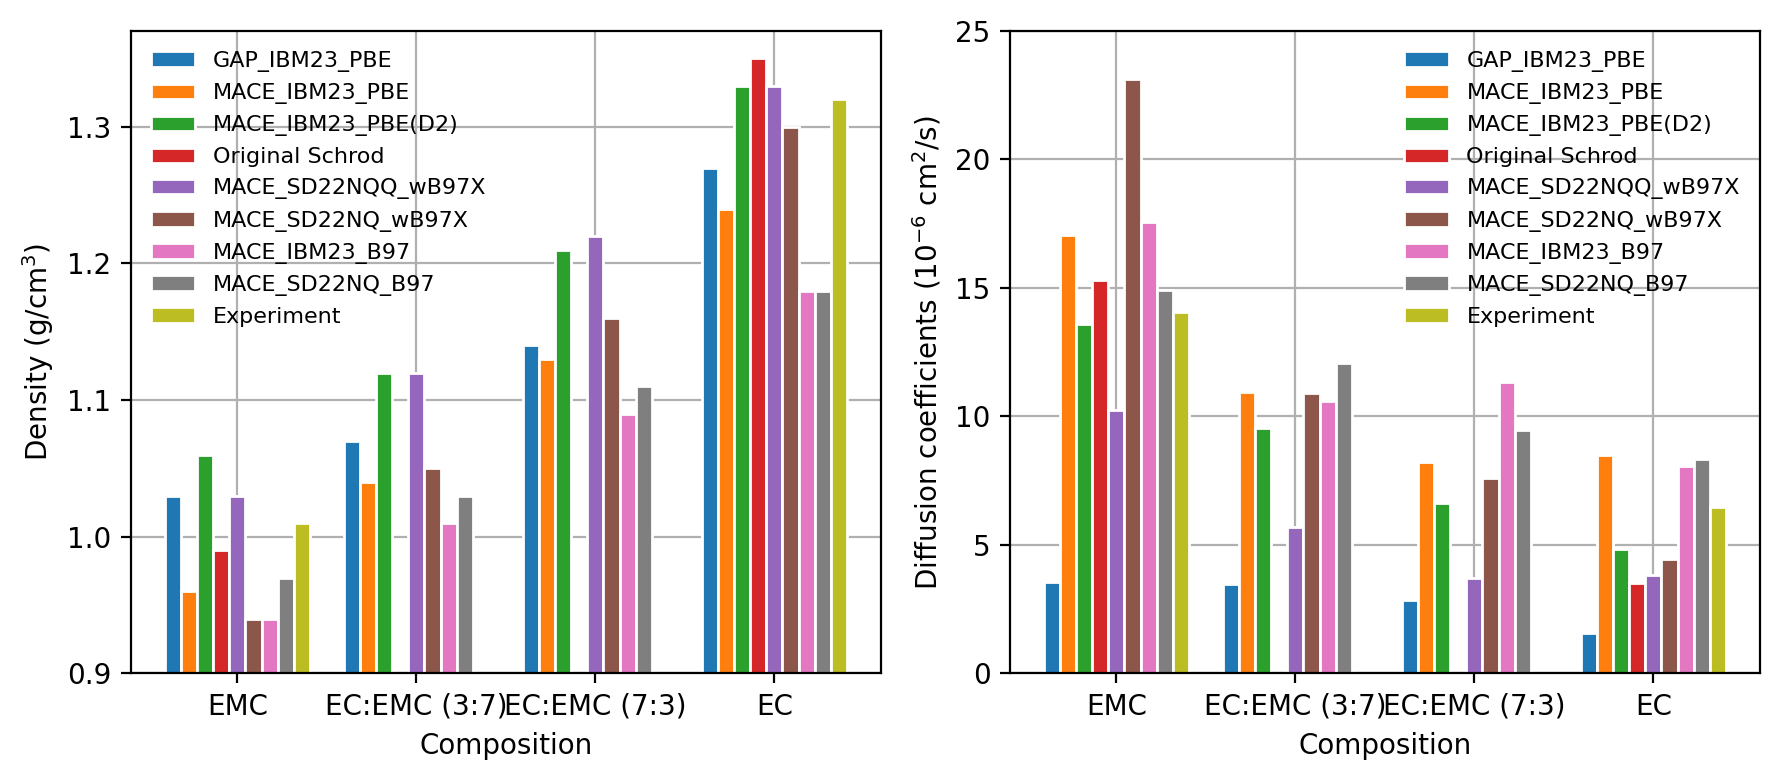

In [82]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.3

def plot_stats(df, prop, ylims, w=0.09):
    N = int(df.shape[0]/2)
    for i,(_, dat) in enumerate(df.iterrows()):
        plt.bar(np.arange(4)+(i-N)*w, [val for k, val in dat.items()], width=w, edgecolor='white', fill=True)
    plt.xticks(np.arange(4), dens_df.columns)
    plt.xlabel('Composition')
    plt.ylabel(prop)
    plt.ylim(ylims)
    plt.legend(df.index, frameon=False, fontsize=8)
    plt.tight_layout()
    plt.grid()
    plt.gca().set_axisbelow(True)

plt.figure(figsize=(10,5), dpi=200)
plt.subplot(1,2,1)
plot_stats(dens_df, prop=r'Density (g/cm$^3$)',  ylims=[0.9, 1.37])
plt.subplot(1,2,2)
plot_stats(diff_df, prop=r'Diffusion coefficients (10$^{-6}$ cm$^2$/s)', ylims=[0,25])

# 1. To Do Numerical Experiments

## make sure all final comparisons are with MACE
- ~~train MACE on td2@10835267 (CP2K PBE+D3 liquid)~~
- ~~run MD/300K all compositions with new model~~

## exclude influence of Dispersion
- ~~run MD/300K all compostions with MACE ml4@10890165 (CASTEP PBE+D2 liquid)~~

## test hypothesis that differences between MACE and Schod come from less data
- train MACE model on full or 50% Schrodinger data neutral
- run MD/300K all compositions with new model

## complete the trajectories: 1ns

# 2. To Do Analysis

## error analysis
- include crude error analysis

## figures
- compile figure illustrating the different Data: Schrodinger and ours

## tables
- define new names for potentials, data, easier to parse
- generate LaTeX tables to include in paper

## exprimental values
- ~~get experimental values from [Wang2022](https://doi.org/10.1016/j.xcrp.2022.101047)~~
- do not fit a model, just take the values we have